# Import Libraries

In [21]:
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import numpy as np
from tensorflow import keras

%load_ext autoreload
%autoreload 2

# Keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

# Keras-Tuner
from kerastuner.tuners import RandomSearch

import cv2 

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

# CNN Class and methods
from src.PR_model_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Description of the Pneumonia Dataset
- The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). 
- There are 5,216 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal). 

# Load Dataset

In [53]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [54]:
train = get_training_data('data/chest_xray/train')
test = get_training_data('data/chest_xray/test')
val = get_training_data('data/chest_xray/val')

<ipython-input-53-b2613b36a4a4>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(data)


# Data Visualization and Preprocessing

/Users/lalithap/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Train')

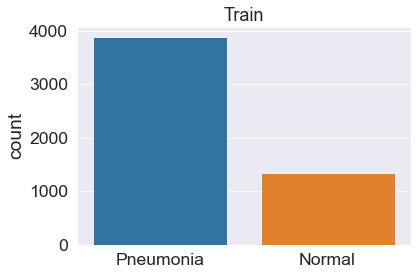

In [55]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.set_context("paper", font_scale=2.0) 
ss = sns.countplot(l)   
ss.axes.set_title("Train",fontsize=18)


## Let's visualize couple of images

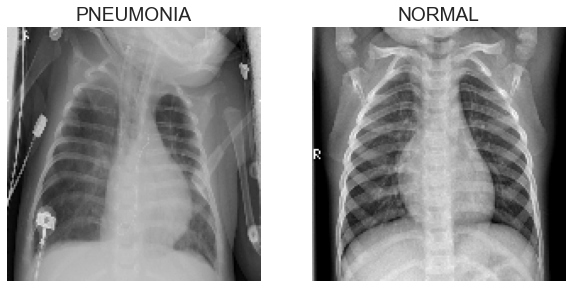

In [56]:
figure = plt.figure(figsize=(10,10))
figure.add_subplot(1, 2, 1)

plt.imshow(train[0][0], cmap='gray'), plt.axis("off")
plt.title(labels[train[0][1]])

figure.add_subplot(1, 2, 2)
plt.imshow(train[-1][0], cmap='gray'), plt.axis("off")
plt.title(labels[train[-1][1]])

plt.show()

## Merge separate x_train,y_train and X_test,y_test and x_val,y_val into three datasets
- X_train is train dataset
- X_test is test dataset
- y_test is validation dataset

In [57]:
'''
    Merge train and test datasets combining both NORMAL and PNEUMONIA X-Rays
'''
X_train = []
y_train = []

X_val = []
y_val = []

X_test = []
y_test = []

for feature, label in train:
    X_train.append(feature)
    y_train.append(label)

for feature, label in test:
    X_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    X_val.append(feature)
    y_val.append(label)

In [58]:
train[0]

array([array([[205, 207, 201, ..., 195, 196, 210],
       [204, 204, 205, ..., 197, 197, 211],
       [205, 204, 203, ..., 204, 210, 215],
       ...,
       [ 18,  13,   9, ...,  47,  50,  51],
       [ 13,  13,  10, ...,  47,  47,  50],
       [ 13,  13,  10, ...,  44,  45,  47]], dtype=uint8),
       0], dtype=object)

## Perform Greyscale Normalization

In [59]:
'''
    Perform grayscale normalization
'''
# Normalize data
X_train = np.array(X_train, dtype=int) / 255
X_val = np.array(X_val, dtype=int) / 255
X_test = np.array(X_test, dtype=int) / 255

In [45]:
type(X_train)

list

## Resize data to prepare for running CNN models

In [62]:
'''
    Resize data for deep learning
''' 
X_train = X_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

X_val = X_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

X_test = X_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [76]:
## Augment dataset, because of class imbalance
datagen = augment_images(X_train)

# Run FSM
1) Call cnn_model utility to intantiate the model.
   cnn_model also sets the default parameters and hyperparameters for construcing CNN layers
2) Build model.
   Build_model takes twoa list of steps as input.
   Model is built in the order of the steps defined as constants strings.

In [80]:
cnn  = cnn_model()
model = cnn.build_model([CONV_2D, FLATTEN_LAYERS])

# Check the learning rate when overfitting happs
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=0,factor=0.3, min_lr=0.000001)

history = model.fit(datagen.flow(X_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(X_val, y_val) ,callbacks = [learning_rate_reduction])

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 150, 150, 32)      320       
_________________________________________________________________
flatten_14 (Flatten)         (None, 720000)            0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 720001    
Total params: 720,321
Trainable params: 720,321
Non-trainable params: 0
_________________________________________________________________
Epoch 1/12
163/163 [==============================] - ETA: 0s - loss: 0.6920 - accuracy: 0.53 - ETA: 26s - loss: 9.1507 - accuracy: 0.640 - ETA: 37s - loss: 6.4033 - accuracy: 0.489 - ETA: 41s - loss: 8.7039 - accuracy: 0.554 - ETA: 43s - loss: 9.3865 - accuracy: 0.562 - ETA: 44s - loss: 9.7309 - accuracy: 0.500 - ETA: 45s - loss: 9.8522 - accuracy: 0.535 - ETA: 46s - loss: 

In [81]:
# Check the learning rate when overfitting happs
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

20/20 [==============================] - ETA: 0s - loss: 0.4088 - accuracy: 0.87 - ETA: 0s - loss: 0.2782 - accuracy: 0.90 - ETA: 0s - loss: 0.3234 - accuracy: 0.87 - ETA: 0s - loss: 0.3379 - accuracy: 0.88 - ETA: 0s - loss: 0.4019 - accuracy: 0.85 - ETA: 0s - loss: 0.3918 - accuracy: 0.86 - ETA: 0s - loss: 0.3724 - accuracy: 0.86 - ETA: 0s - loss: 0.3615 - accuracy: 0.86 - ETA: 0s - loss: 0.3633 - accuracy: 0.86 - ETA: 0s - loss: 0.3489 - accuracy: 0.86 - ETA: 0s - loss: 0.3727 - accuracy: 0.84 - ETA: 0s - loss: 0.3870 - accuracy: 0.83 - ETA: 0s - loss: 0.4032 - accuracy: 0.82 - ETA: 0s - loss: 0.4332 - accuracy: 0.81 - ETA: 0s - loss: 0.4386 - accuracy: 0.81 - 1s 45ms/step - loss: 0.4550 - accuracy: 0.8093
Loss of the model is -  0.45504966378211975
20/20 [==============================] - ETA: 0s - loss: 0.4088 - accuracy: 0.87 - ETA: 0s - loss: 0.3168 - accuracy: 0.88 - ETA: 0s - loss: 0.3379 - accuracy: 0.88 - ETA: 0s - loss: 0.3918 - accuracy: 0.86 - ETA: 0s - loss: 0.3724 - accu

In [ ]:
''' 
    data augmentation to prevent overfitting and handling the imbalance in dataset

'''
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [ ]:
'''
    Training the model
'''

model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()


# Check the learning rate when overfitting happs
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

# Analysis after Model Training

In [ ]:

epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

In [ ]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

In [ ]:
cm = confusion_matrix(y_test,predictions)
cm

In [ ]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [ ]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

# Some of the Correctly Predicted Classes

In [ ]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

# Some of the Incorrectly Predicted Classes

In [ ]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

# Prabhakar Models

In [ ]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(Flatten())
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['Recall'])
model.summary()
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)


In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

In [ ]:
history.history

In [ ]:
    plot_resultshs = [i for i in range(12)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['recall']
    train_loss = history.history['loss']
    val_acc = history.history['val_recall']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)

    ax[0].plot(epochs , train_acc , 'go-' , label = 'Loss')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Recall")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Testing Accuracy & Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()

In [ ]:
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

In [ ]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

In [ ]:
cm = confusion_matrix(y_test,predictions)
cm

In [ ]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)